In [166]:
import numpy as np, pandas as pd, tensorflow as tf
import lightgbm as lgb
import matplotlib.pyplot as plt
import yfinance as yf
from tensorflow.keras.utils import timeseries_dataset_from_array as loader
from UTILS import train_test_split_ts, forward_garch
from arch import arch_model
import pyfiglet
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,4)
plt.rcParams['font.size'] = 15

In [362]:
def nll_gb_exp(y_hat, data):
    #y_hat = log(sigma**2)
    y = data.get_label()
    grad = .5*(np.ones_like(y) - y**2*np.exp(-1*y_hat))
    hess = .5*(y**2*np.exp(-1*y_hat))
    return grad, hess

def nll_gb_exp_eval(y_hat, data):
    y = data.get_label()
    return 'NLL', .5*np.sum(np.log(2*np.pi)+y_hat+y**2*np.exp(-1*y_hat)), False

def nll_gb_exp_eval_from_np(y_hat, y):
    return .5*np.sum(np.log(2*np.pi)+y_hat+y**2*np.exp(-1*y_hat))

def take_X_y(rets, lag):
#     rets = rets.values-rets.mean()
    load = loader(
        data = rets, 
        targets = rets[lag:],
        sequence_length = lag,
        batch_size = rets.shape[0]
    )
    for X, y in load:
        return X.numpy().astype('float32'), y.numpy().reshape(-1,1).astype('float32')

In [486]:
prices = yf.Ticker('^GSPC').history(start = '2005-01-01').Close
rets = 100*(prices.pct_change().dropna())
rets_train, rets_test = train_test_split_ts(rets, .7)

In [492]:
# garch = arch_model(rets_train, mean = 'Constant', vol = 'GARCH', p=1, q=1)
# fit = garch.fit(disp = False)
# g_vol = fit.conditional_volatility.values

# matrix = np.concatenate((rets_train.values.reshape(-1,1), g_vol.reshape(-1,1)),1)

# lag = 5
# data = loader(
#     data = matrix,
#     targets = rets_train.values[lag:],
#     sequence_length = lag,
#     batch_size = matrix.shape[0]
# )

# for X,y in data:
#     X, y = X.numpy(), y.numpy()
#     X = np.reshape(X, (X.shape[0],2*lag))
#     print(X, X.shape)
#     print(y, y.shape)

In [487]:
#without garch vola as feature
lag = 50
X_train, y_train = take_X_y(rets_train, lag)
X_test, y_test = take_X_y(rets_test, lag)
lgb_train, lgb_test = lgb.Dataset(X_train, y_train, free_raw_data=False ),\
lgb.Dataset(X_test, y_test,  free_raw_data=False )

In [488]:
lgbm_params = {
    'num_leaves'  : 2,
    'max_depth':1,
    'learning_rate' : .25,
    'boosting':'gbdt',
    'num_iterations':200,
    'force_col_wise ':'true',
    'early_stopping_round':10,
    'tree_learner': 'serial' ,
    'bagging_fraction': 1,
    'feature_fraction': 1,
    'extra_trees':'true'
}

model = lgb.train(
    params = lgbm_params,
    train_set = lgb_train,
    valid_sets = lgb_test,
    fobj  = nll_gb_exp,
    feval = nll_gb_exp_eval    
)

[LightGBM] [Warning] Unknown parameter: true
[LightGBM] [Warning] Unknown parameter: true
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 2990, number of used features: 50
[LightGBM] [Warning] Unknown parameter: true
[LightGBM] [Warning] Using self-defined objective function
[1]	valid_0's NLL: 2083.93
Training until validation scores don't improve for 10 rounds
[2]	valid_0's NLL: 2033.47
[3]	valid_0's NLL: 2018.98
[4]	valid_0's NLL: 1988.6
[5]	valid_0's NLL: 1973.55
[6]	valid_0's NLL: 1954.73
[7]	valid_0's NLL: 1924.25
[8]	valid_0's NLL: 1899.07
[9]	valid_0's NLL: 1892.28
[10]	valid_0's NLL: 1874.03
[11]	valid_0's NLL: 1859.68
[12]	valid_0's NLL: 1853.12
[13]	valid_0's NLL: 1854.48
[14]	valid_0's NLL: 1846.8
[15]	valid_0'

C:\Users\Giorgio\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Giorgio\anaconda3\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


************************************************************
              __  __  ___  ____  _____ _     
             |  \/  |/ _ \|  _ \| ____| |    
             | |\/| | | | | | | |  _| | |    
             | |  | | |_| | |_| | |___| |___ 
             |_|  |_|\___/|____/|_____|_____|
                                             
 _______     ___    _    _   _   _  _____ ___ ___  _   _ 
| ____\ \   / / \  | |  | | | | / \|_   _|_ _/ _ \| \ | |
|  _|  \ \ / / _ \ | |  | | | |/ _ \ | |  | | | | |  \| |
| |___  \ V / ___ \| |__| |_| / ___ \| |  | | |_| | |\  |
|_____|  \_/_/   \_\_____\___/_/   \_\_| |___\___/|_| \_|
                                                         

************************************************************


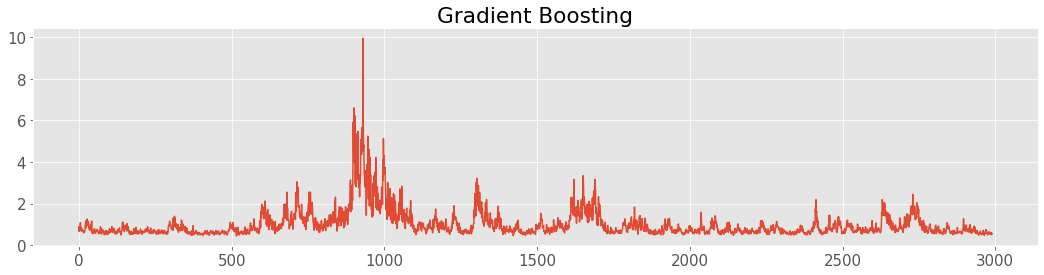

GB NLL:   3869


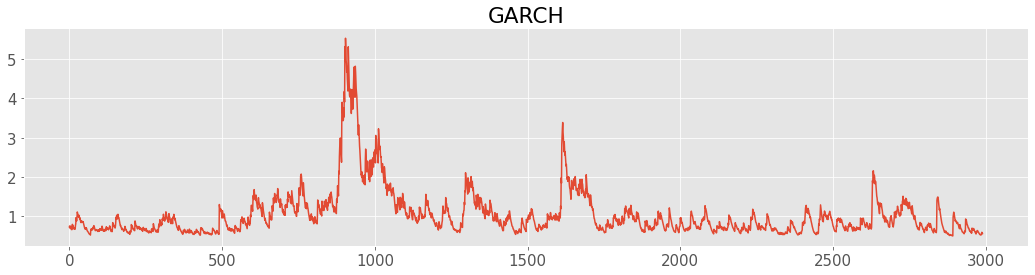

Garch NLL:   4033


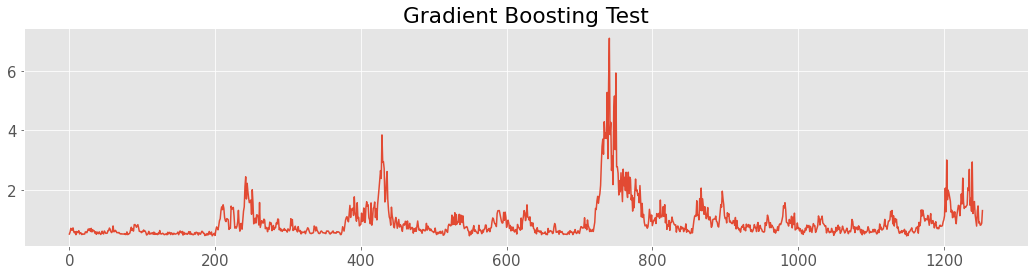

GB NLL:   1605


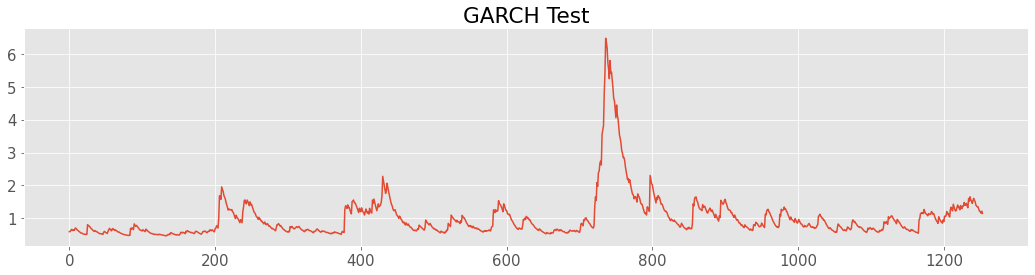

Garch NLL:   1611


In [489]:
print(60*'*')
print(pyfiglet.figlet_format("             MODEL\nEVALUATION"))
print(60*'*')

out = model.predict(X_train)
plt.plot(np.exp(out)**.5)
plt.title('Gradient Boosting')
plt.show()

print('GB NLL: {:6.0f}'.format(nll_gb_exp_eval_from_np(out, lgb_train.get_label())))

garch = arch_model(lgb_train.get_label(), mean = 'Constant', vol = 'GARCH', p=1, q=1)
fit = garch.fit(disp = False)
g_vol = fit.conditional_volatility

plt.plot(g_vol)
plt.title('GARCH')
plt.show()
print('Garch NLL: {:6.0f}'.format(nll_gb_exp_eval_from_np(np.log(g_vol**2), lgb_train.get_label())))

plt.plot(np.exp(model.predict(X_test))**.5)
plt.title('Gradient Boosting Test')
plt.show()
print('GB NLL: {:6.0f}'.format(nll_gb_exp_eval(model.predict(X_test), lgb_test)[1]))


g_vola_pred = forward_garch(tf.convert_to_tensor(y_test), tf.convert_to_tensor(y_train), fit).numpy().ravel()
plt.plot(g_vola_pred)
plt.title('GARCH Test')
plt.show()
print('Garch NLL: {:6.0f}'.format(nll_gb_exp_eval_from_np(np.log(g_vola_pred**2), lgb_test.get_label())))